In [14]:
import os
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# results_df

# Barchart Workload

In [16]:
RESULTS_PATH = os.curdir + "/results/load-based-N-fields/tpch/2025-03-26-15H"
results_df = pd.read_csv(RESULTS_PATH + '/meta_results.csv')
results_df.tail()

,index,Query proportion,Majority proportion,Load,Treshold,Test,Time to prepare db,Total query time,Blocks used,Block size,Database size,Materialized Columns,Majority Queries,Materialization
215,206,4,400,9,30.0,load_based_m30,20.091908,178.345982,2157,262144,565444608,30,"['q10', 'q13', 'q16', 'q21']","['o_orderkey', 's_suppkey', 'l_orderkey', 'n_n..."
216,207,4,400,9,35.0,load_based_m35,23.365705,70.589120,2273,262144,595853312,35,"['q10', 'q13', 'q16', 'q21']","['o_orderkey', 's_suppkey', 'l_orderkey', 'n_n..."
217,9,4,400,9,NaN,no_materialization,0.000000,2214.422638,2018,262144,529006592,0,"['q6', 'q10', 'q13', 'q16']",[]
218,209,4,400,9,NaN,schema_based_materialization,10.632792,1290.327401,2314,262144,606601216,16,"['q10', 'q13', 'q16', 'q21']","['l_orderkey', 'l_suppkey', 'l_partkey', 'l_re..."
219,208,4,400,9,NaN,full_materialization,37.625530,25.370490,495,262144,129761280,57,"['q10', 'q13', 'q16', 'q21']","['c_custkey', 'c_nationkey', 'c_mktsegment', '..."


0                     load_based_m1
1                     load_based_m2
2                     load_based_m3
3                     load_based_m4
4                     load_based_m5
                   ...             
215                  load_based_m30
216                  load_based_m35
217              no_materialization
218    schema_based_materialization
219            full_materialization
Name: Test, Length: 220, dtype: category
Categories (22, object): ['full_materialization' < 'schema_based_materialization' < 'no_materialization' < 'load_based_m1' ... 'load_based_m20' < 'load_based_m25' < 'load_based_m30' < 'load_based_m35']


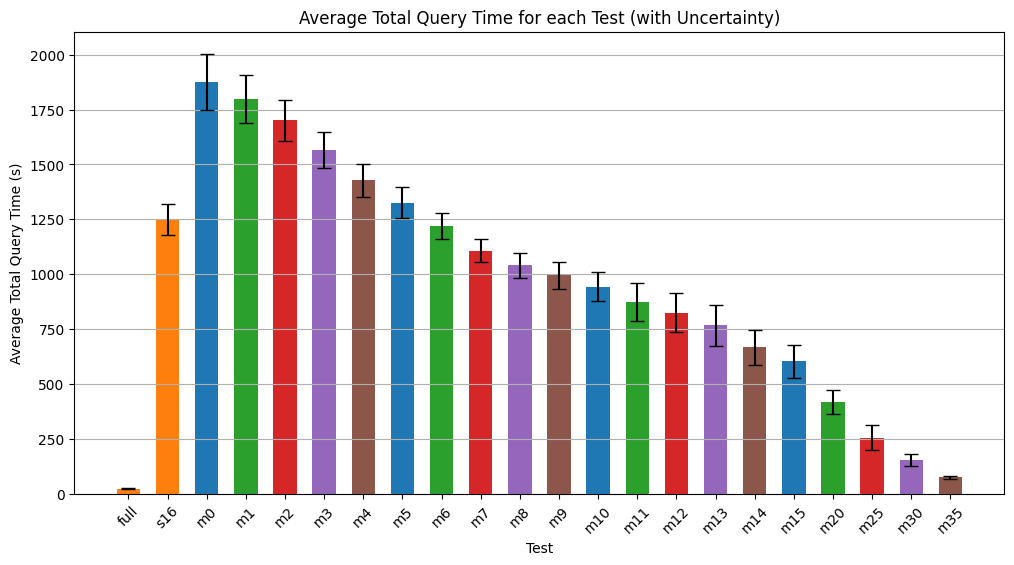

In [17]:
# Function to count the number of materialized fields from the string representation
def count_materialized_fields(s: str):
    try:
        # Converts the string representation to a python list
        fields = ast.literal_eval(s)
        return len(fields)
    except Exception as e:
        print(e)


# Create a new column with the number of materialized fields
results_df["num_materialized_fields"] = results_df["Materialization"].apply(
    count_materialized_fields)

subset = results_df[(results_df["Total query time"] > 0)]
# Subset rows where Test starts with "load_based_t"
load_based = subset[subset["Test"].str.startswith("load_based_m")]

# Subset rows with Test equal to "schema_based_materialization"
schema_based = subset[subset["Test"] == "schema_based_materialization"]

# Merge the two dataframes on the columns "Query proportion", "Majority proportion", and "Load"
merged = pd.merge(
    load_based,
    schema_based,
    on=["Query proportion", "Majority proportion", "Load"],
    suffixes=('_load', '_schema')
)
# Compute the ratio between the total query time of the load_based row and the corresponding schema_based row
merged["query_time_ratio"] = merged["Total query time_load"] / \
    merged["Total query time_schema"]

# Define new color mapping for all tests (adjust as needed)
colors = {
    "full_materialization": "#FF7F0E",  # Bright orange for clear visibility
    "schema_based_materialization": "#FF7F0E",  # Bright orange for clear visibility

    "no_materialization":  "#1f77b4",  # Blue
    "load_based_m1":  "#2ca02c",  # Green
    "load_based_m2":  "#d62728",  # Red
    "load_based_m3":  "#9467bd",  # Purple
    "load_based_m4":  "#8c564b",  # Brown

    "load_based_m5":  "#1f77b4",  # Blue
    "load_based_m6":  "#2ca02c",  # Green
    "load_based_m7":  "#d62728",  # Red
    "load_based_m8":  "#9467bd",  # Purple
    "load_based_m9":  "#8c564b",  # Brown

    "load_based_m10": "#1f77b4",  # Blue
    "load_based_m11": "#2ca02c",  # Green
    "load_based_m12": "#d62728",  # Red
    "load_based_m13": "#9467bd",  # Purple
    "load_based_m14": "#8c564b",  # Brown

    "load_based_m15": "#1f77b4",  # Blue
    "load_based_m20": "#2ca02c",  # Green
    "load_based_m25": "#d62728",  # Red
    "load_based_m30": "#9467bd",  # Purple
    "load_based_m35": "#8c564b",  # Brown
}

# Define the test order using all keys from the colors dictionary
test_order = list(colors.keys())


def shorten_label_into_number(test:str):
    if test == "schema_based_materialization":
        return 16
    elif test.startswith("load_based_"):
        return int((test.split("_")[-1])[1:])
    elif test.lower() == "no_materialization":
        return 0
    else:
        return test


# Filter the DataFrame for the tests in test_order
df_current = results_df[results_df["Test"].isin(test_order)].copy()

# Group by Test to compute statistics for Total query time
grouped_total_query_time = df_current.groupby("Test")["Total query time"].agg(
    mean="mean", std="std", count="count", max="max", min="min"
).reset_index()
grouped_total_query_time["stderr"] = grouped_total_query_time["std"] / \
    np.sqrt(grouped_total_query_time["count"])

# Ensure that the tests are ordered as in test_order (this line is kept if needed for other purposes)
grouped_total_query_time["Test"] = pd.Categorical(
    grouped_total_query_time["Test"], categories=test_order, ordered=True
)
results_df["Test"] = pd.Categorical(
    results_df["Test"], categories=test_order, ordered=True
)

# Instead of sorting by mean, we sort by the numeric value from shorten_label_into_number
grouped_total_query_time = grouped_total_query_time.sort_values(
    by="Test", key=lambda col: col.map(shorten_label_into_number)
)
# 

# Helper function to shorten the labels
def shorten_label(test):
    if test == "schema_based_materialization":
        return "s16"
    elif test.startswith("load_based_"):
        return test.split("_")[-1]
    elif test.lower() == "no_materialization":
        return "m0"
    elif test.lower() == "full_materialization":
        return "full"
    else:
        return test


# Create the list of shortened labels
short_labels = [shorten_label(test)
                for test in grouped_total_query_time["Test"]]

# Add shortened label to grouped_total_query_time
grouped_total_query_time["test label"] = grouped_total_query_time.apply(lambda row: shorten_label(row["Test"]), axis=1)

print(results_df["Test"])

results_df["test label"] = results_df.apply(lambda row: shorten_label(row["Test"]), axis=1)

# Common x positions and bar width
x = np.arange(len(grouped_total_query_time))
bar_width = 0.6

# Define plot configurations in a loop
plot_configs = [
    {"mode": "errorbar",
        "title": "Average Total Query Time for each Test (with Uncertainty)"},
    # {"mode": "minmax",
    #     "title": "Total Query Time for each Test (with Min and Max Values)"}
]

for config in plot_configs:
    fig, ax = plt.subplots(figsize=(12, 6))
    mode = config["mode"]

    if mode == "errorbar":
        # Plot bars with error bars for standard error
        ax.bar(
            x,
            grouped_total_query_time["mean"],
            bar_width,
            color=[colors[test] for test in grouped_total_query_time["Test"]],
            yerr=grouped_total_query_time["stderr"],
            capsize=5
        )
    # elif mode == "minmax":
    #     # Plot bars without error bars
    #     ax.bar(
    #         x,
    #         grouped_total_query_time["mean"],
    #         bar_width,
    #         color=[colors[test] for test in grouped_total_query_time["Test"]],
    #         capsize=5
    #     )
    #     # Overlay dashed lines and markers for min and max values
    #     for i, (_, row) in enumerate(grouped_total_query_time.iterrows()):
    #         ax.plot([x[i], x[i]], [row["min"], row["max"]],
    #                 linestyle="--", color="black", linewidth=1.5)
    #         ax.scatter(x[i], row["min"], color="black", marker="v", s=50)
    #         ax.scatter(x[i], row["max"], color="black", marker="^", s=50)

    ax.set_xticks(x)
    ax.set_xticklabels(short_labels, rotation=45)
    ax.set_xlabel("Test")
    ax.set_ylabel("Average Total Query Time (s)")
    ax.set_title(config["title"])
    ax.grid(True, axis='y')

In [ ]:
def _mean(label):
    return round(grouped_total_query_time[grouped_total_query_time["test label"] == label]["mean"].iloc[0],2)
def _err(label):
    err = round(grouped_total_query_time[grouped_total_query_time["test label"] == label]["stderr"].iloc[0],2)
    return f"{err},{err}"

gigantic_f_string = f"""
\\begin{{tikzpicture}}
        \\begin{{axis}}[
            ybar,   
            axis lines=box,
            width=1\\textwidth,   
            xtick pos=bottom,
            ytick pos=left,
            height=6cm,               
            xlabel={{Test}},
            ylabel={{Total Query Time (s)}},
            title={{Load 1: Total Query Time}},
            symbolic x coords={{
                m0, 
                m1, 
                m2,
                m3,
                m4,
                m5,
                m6,
                m7,
                m8,
                m9,
                m10,
                m11,
                m12,
                m13,
                m14,
                m15,
                s16,
                m20,
                m25,
                m30,
                m35
            }},
            xtick={{
                m0, 
                m1, 
                m2,
                m3,
                m4,
                m5,
                m6,
                m7,
                m8,
                m9,
                m10,
                m11,
                m12,
                m13,
                m14,
                m15,
                s16,
                m20,
                m25,
                m30,
                m35
            }},           
            x tick label style={{
                rotate=45,
                anchor=east
            }},
            ymin=0,
            ytick={{0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000}},
            ymajorgrids=true
        ]
        
        \\addplot+[
            draw=none,
            fill=red, 
            bar shift=0pt,
            error bars/.cd,
                y dir=both,
                y explicit,
                error bar style={{black}}
        ] coordinates {{                
            (s16,{_mean("s16")}) +- ({_err("s16")})
        }};

        \\addplot+[
            draw=none,
            fill=green, 
            bar shift=0pt,
            error bars/.cd,
                y dir=both,
                y explicit,
                error bar style={{black}}
        ] coordinates {{  
            (m20,{_mean("m20")}) +- ({_err("m20")})           
            (m25,{_mean("m25")}) +- ({_err("m25")})           
            (m30,{_mean("m30")}) +- ({_err("m30")})           
            (m35,{_mean("m35")}) +- ({_err("m35")})           
        }};
        
      \\addplot+[
        bar shift=0pt,
        draw=none, 
        fill=blue,
        error bars/.cd,
                y dir=both,
                y explicit,
                error bar style={{black}}
      ] coordinates {{
        (m0,{_mean("m0")}) +- ({_err("m0")})
        (m1,{_mean("m1")}) +- ({_err("m1")})
        (m2,{_mean("m2")}) +- ({_err("m2")})
        (m3,{_mean("m3")}) +- ({_err("m3")})
        (m4,{_mean("m4")}) +- ({_err("m4")})
        (m5,{_mean("m5")}) +- ({_err("m5")})
        (m6,{_mean("m6")}) +- ({_err("m6")})
        (m7,{_mean("m7")}) +- ({_err("m7")})
        (m8,{_mean("m8")}) +- ({_err("m8")})
        (m9,{_mean("m9")}) +- ({_err("m9")})
        (m10,{_mean("m10")}) +- ({_err("m10")})
        (m11,{_mean("m11")}) +- ({_err("m11")})
        (m12,{_mean("m12")}) +- ({_err("m12")})
        (m13,{_mean("m13")}) +- ({_err("m13")})
        (m14,{_mean("m14")}) +- ({_err("m14")})
        (m15,{_mean("m15")}) +- ({_err("m15")})
      }};
        \\end{{axis}}
        \\end{{tikzpicture}}
"""
print(gigantic_f_string)


\begin{tikzpicture}
        \begin{axis}[
            ybar,   
            axis lines=box,
            width=1\textwidth,   
            xtick pos=bottom,
            ytick pos=left,
            height=6cm,               
            xlabel={Test},
            ylabel={Total Query Time (s)},
            title={Load 1: Total Query Time},
            symbolic x coords={
                m0, 
                m1, 
                m2,
                m3,
                m4,
                m5,
                m6,
                m7,
                m8,
                m9,
                m10,
                m11,
                m12,
                m13,
                m14,
                m15,
                s16,
                m20,
                m25,
                m30,
                m35
            },
            xtick={
                m0, 
                m1, 
                m2,
                m3,
                m4,
                m5,
                m6,
                m7,


In [ ]:
def _time(label, load):
    return round(results_df[(results_df["test label"] == label) & (results_df["Load"] == load)]["mean"].iloc[0], 2)


def _load_barchart(load):
    return f"""
    \\begin{{tikzpicture}}
            \\begin{{axis}}[
                ybar,   
                axis lines=box,
                width=1\\textwidth,   
                xtick pos=bottom,
                ytick pos=left,
                height=6cm,               
                xlabel={{Test}},
                ylabel={{Total Query Time (s)}},
                title={{Load 1: Total Query Time}},
                symbolic x coords={{
                    m0, 
                    m1, 
                    m2,
                    m3,
                    m4,
                    m5,
                    m6,
                    m7,
                    m8,
                    m9,
                    m10,
                    m11,
                    m12,
                    m13,
                    m14,
                    m15,
                    s16,
                    m20,
                    m25,
                    m30,
                    m35
                }},
                xtick={{
                    m0, 
                    m1, 
                    m2,
                    m3,
                    m4,
                    m5,
                    m6,
                    m7,
                    m8,
                    m9,
                    m10,
                    m11,
                    m12,
                    m13,
                    m14,
                    m15,
                    s16,
                    m20,
                    m25,
                    m30,
                    m35
                }},           
                x tick label style={{
                    rotate=45,
                    anchor=east
                }},
                ymin=0,
                ytick={{0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000}},
                ymajorgrids=true
            ]
            
            \\addplot+[
                draw=none,
                fill=red, 
                bar shift=0pt,
                error bars/.cd,
                    y dir=both,
                    y explicit,
                    error bar style={{black}}
            ] coordinates {{                
                (s16,{_time(label="s16", load=load)}) 
            }};

            \\addplot+[
                draw=none,
                fill=green, 
                bar shift=0pt,
                error bars/.cd,
                    y dir=both,
                    y explicit,
                    error bar style={{black}}
            ] coordinates {{  
                (m20,{_time(label="m20", load=load)}) 
                (m25,{_time(label="m25", load=load)}) 
                (m30,{_time(label="m30", load=load)}) 
                (m35,{_time(label="m35", load=load)}) 
            }};
            
        \\addplot+[
            bar shift=0pt,
            draw=none, 
            fill=blue,
            error bars/.cd,
                    y dir=both,
                    y explicit,
                    error bar style={{black}}
        ] coordinates {{
            (m0,{_time(label="m0", load=load)}) 
            (m1,{_time(label="m1", load=load)}) 
            (m2,{_time(label="m2", load=load)}) 
            (m3,{_time(label="m3", load=load)}) 
            (m4,{_time(label="m4", load=load)}) 
            (m5,{_time(label="m5", load=load)}) 
            (m6,{_time(label="m6", load=load)}) 
            (m7,{_time(label="m7", load=load)}) 
            (m8,{_time(label="m8", load=load)}) 
            (m9,{_time(label="m9", load=load)}) 
            (m10,{_time(label="m10", load=load)}) 
            (m11,{_time(label="m11", load=load)}) 
            (m12,{_time(label="m12", load=load)}) 
            (m13,{_time(label="m13", load=load)}) 
            (m14,{_time(label="m14", load=load)}) 
            (m15,{_time(label="m15", load=load)}) 
        }};
            \\end{{axis}}
            \\end{{tikzpicture}}
    """

In [20]:
results_df

,index,Query proportion,Majority proportion,Load,Treshold,Test,Time to prepare db,Total query time,Blocks used,Block size,Database size,Materialized Columns,Majority Queries,Materialization,num_materialized_fields,test label
0,0,4,400,0,1.0,load_based_m1,1.100965,1737.077425,2030,262144,532152320,1,"['q2', 'q10', 'q14', 'q15']",['l_extendedprice'],1,m1
1,1,4,400,0,2.0,load_based_m2,1.817903,1717.975765,2037,262144,533987328,2,"['q2', 'q10', 'q14', 'q15']","['l_extendedprice', 'l_discount']",2,m2
2,2,4,400,0,3.0,load_based_m3,2.446275,1558.094478,2060,262144,540016640,3,"['q2', 'q10', 'q14', 'q15']","['l_extendedprice', 'l_discount', 'l_shipdate']",3,m3
3,3,4,400,0,4.0,load_based_m4,3.089095,1472.273624,2060,262144,540016640,4,"['q2', 'q10', 'q14', 'q15']","['l_extendedprice', 'l_discount', 'l_shipdate'...",4,m4
4,4,4,400,0,5.0,load_based_m5,3.783206,1176.333647,2060,262144,540016640,5,"['q2', 'q10', 'q14', 'q15']","['l_extendedprice', 'l_discount', 'l_shipdate'...",5,m5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,206,4,400,9,30.0,load_based_m30,20.091908,178.345982,2157,262144,565444608,30,"['q10', 'q13', 'q16', 'q21']","['o_orderkey', 's_suppkey', 'l_orderkey', 'n_n...",30,m30
216,207,4,400,9,35.0,load_based_m35,23.365705,70.589120,2273,262144,595853312,35,"['q10', 'q13', 'q16', 'q21']","['o_orderkey', 's_suppkey', 'l_orderkey', 'n_n...",35,m35
217,9,4,400,9,NaN,no_materialization,0.000000,2214.422638,2018,262144,529006592,0,"['q6', 'q10', 'q13', 'q16']",[],0,m0
218,209,4,400,9,NaN,schema_based_materialization,10.632792,1290.327401,2314,262144,606601216,16,"['q10', 'q13', 'q16', 'q21']","['l_orderkey', 'l_suppkey', 'l_partkey', 'l_re...",16,s16
